## 01. Install and Import Libraries

In [4]:
# !pip install pandas numpy matplotlib seaborn scikit-learn nltk tensorflow joblib --quiet

import pandas as pd
import numpy as np
import zipfile
import re
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

## 02. Download NLTK stopwords

In [5]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 03. Extract Dataset

In [6]:
zip_path = '/content/archive.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./data')

df = pd.read_csv('./data/cyberbullying_tweets.csv')

## 04. Clean Text

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"\d+", "", text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['clean_text'] = df['tweet_text'].apply(clean_text)

## 05. Encode Labels

In [8]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['cyberbullying_type'])
label_map = dict(zip(le.transform(le.classes_), le.classes_))

## 06. Vectorize and Split

In [9]:
X = df['clean_text']
y = df['label']
y_cat = to_categorical(y)

vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2), min_df=5)
X_vec = vectorizer.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y_cat, test_size=0.2, random_state=42, stratify=y
)

## 07. Class Weights for Imbalanced Data

In [10]:
y_train_single = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train_single), y=y_train_single
)
class_weights_dict = dict(enumerate(class_weights))

## 08. Build Model with updated architecture

In [11]:
model = Sequential([
    Dense(128, input_shape=(3000,), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

optimizer = Adam(learning_rate=1e-4)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 09. Train Model with updated EarlyStopping and batch size

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

Epoch 1/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.3424 - loss: 4.5409 - val_accuracy: 0.7526 - val_loss: 2.7435
Epoch 2/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6905 - loss: 2.7959 - val_accuracy: 0.7968 - val_loss: 2.1502
Epoch 3/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7621 - loss: 2.1488 - val_accuracy: 0.8072 - val_loss: 1.7166
Epoch 4/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7941 - loss: 1.6897 - val_accuracy: 0.8125 - val_loss: 1.3803
Epoch 5/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8156 - loss: 1.3516 - val_accuracy: 0.8148 - val_loss: 1.1390
Epoch 6/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8316 - loss: 1.0964 - val_accuracy: 0.8185 - val_loss: 0.9671
Epoch 7/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8343 - loss: 0.9269 - val_accuracy: 0.8213 - val_loss: 0.8538
Epoch 8/30
954/954 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8476 - loss: 0.7860 - val_accuracy: 0

## 10. Save Model & Preprocessors

In [13]:
model.save("cyberbullying_model.h5")
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

## 11. Evaluate Model

In [14]:
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f}")

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8099 - loss: 0.6455

✅ Test Accuracy: 0.8096


## 12. Plot Accuracy

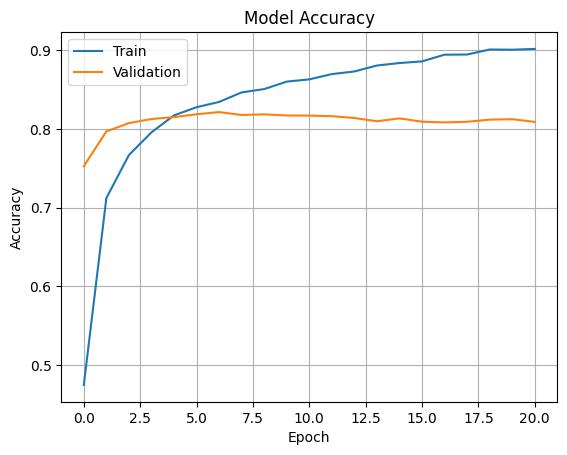

In [15]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

## 13.  Confusion Matrix & Report

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


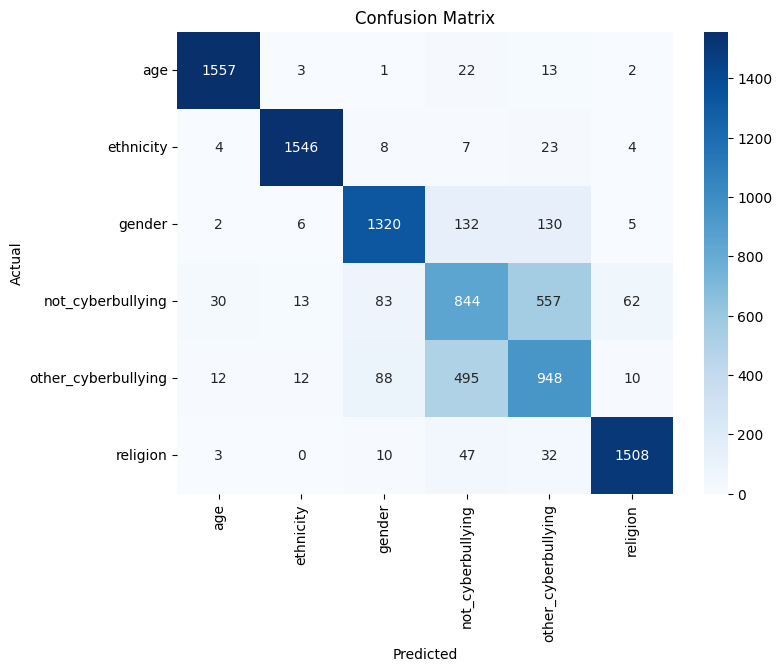


📊 Classification Report:
                     precision    recall  f1-score   support

                age       0.97      0.97      0.97      1598
          ethnicity       0.98      0.97      0.97      1592
             gender       0.87      0.83      0.85      1595
  not_cyberbullying       0.55      0.53      0.54      1589
other_cyberbullying       0.56      0.61      0.58      1565
           religion       0.95      0.94      0.95      1600

           accuracy                           0.81      9539
          macro avg       0.81      0.81      0.81      9539
       weighted avg       0.81      0.81      0.81      9539

🎯 Precision: 0.8128722458670538
🎯 Recall: 0.8096236502778069
🎯 F1 Score: 0.8109500348495929


In [16]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))
print("🎯 Precision:", precision_score(y_true, y_pred_classes, average='weighted'))
print("🎯 Recall:", recall_score(y_true, y_pred_classes, average='weighted'))
print("🎯 F1 Score:", f1_score(y_true, y_pred_classes, average='weighted'))

## 14. Live Prediction

In [17]:
def predict_live(text):
    cleaned = clean_text(text)
    vect = vectorizer.transform([cleaned])
    pred = model.predict(vect.toarray())
    return le.inverse_transform([np.argmax(pred)])[0]

## 15. Test in Loop

In [19]:
print("\n🔍 LIVE PREDICTION (type 'exit' to stop):")
while True:
    user_input = input("\nEnter a tweet:\n")
    if user_input.lower() == 'exit':
        break
    prediction = predict_live(user_input)
    print("📌 Predicted Cyberbullying Type:", prediction)


🔍 LIVE PREDICTION (type 'exit' to stop):

Enter a tweet:
bitch get up off me
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
📌 Predicted Cyberbullying Type: gender

Enter a tweet:
bitches get cut off everyday
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
📌 Predicted Cyberbullying Type: gender

Enter a tweet:
if you ant bout that Murder Game pussy nigga shut up
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📌 Predicted Cyberbullying Type: ethnicity

Enter a tweet:
these hoes like niggas that spend money not talk bout it
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📌 Predicted Cyberbullying Type: ethnicity

Enter a tweet:
quick piece of pussy call it a drive by
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
📌 Predicted Cyberbullying Type: other_cyberbullying

Enter a tweet:
running round here like some brand new pussy that's bout to get fucked
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
📌 Predicted Cyberbullying Type: other_cyberbullying

Enter a tweet:
I hate mint - I once kicked a classmate in the balls in grade school because he wa